model.safetensors:   0%|          | 0.00/89.8M [00:00<?, ?B/s]

d:\miniconda\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\intel\.cache\huggingface\hub\models--timm--deit_small_distilled_patch16_224.fb_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


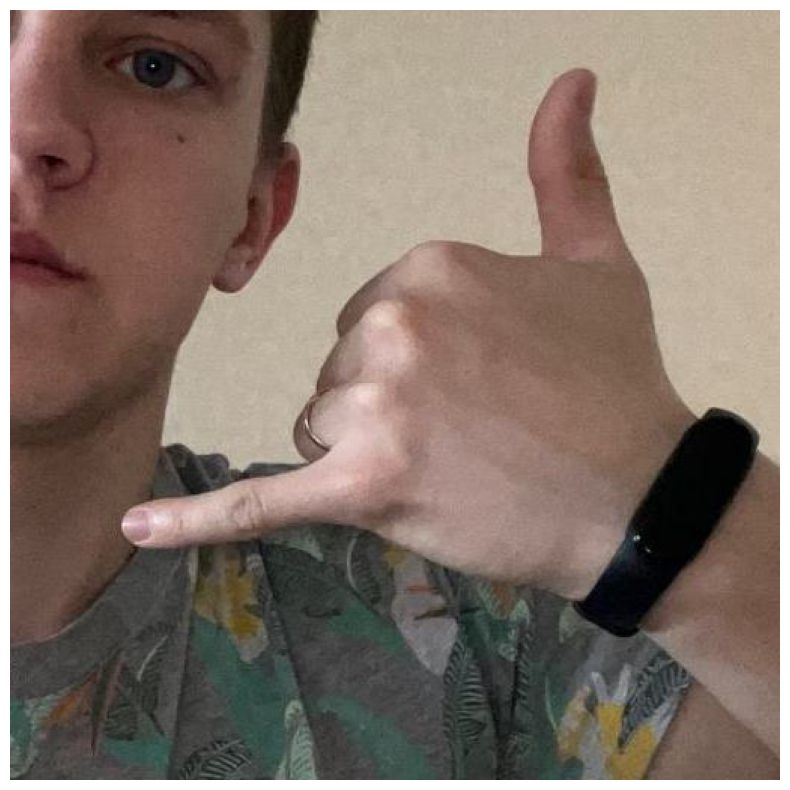

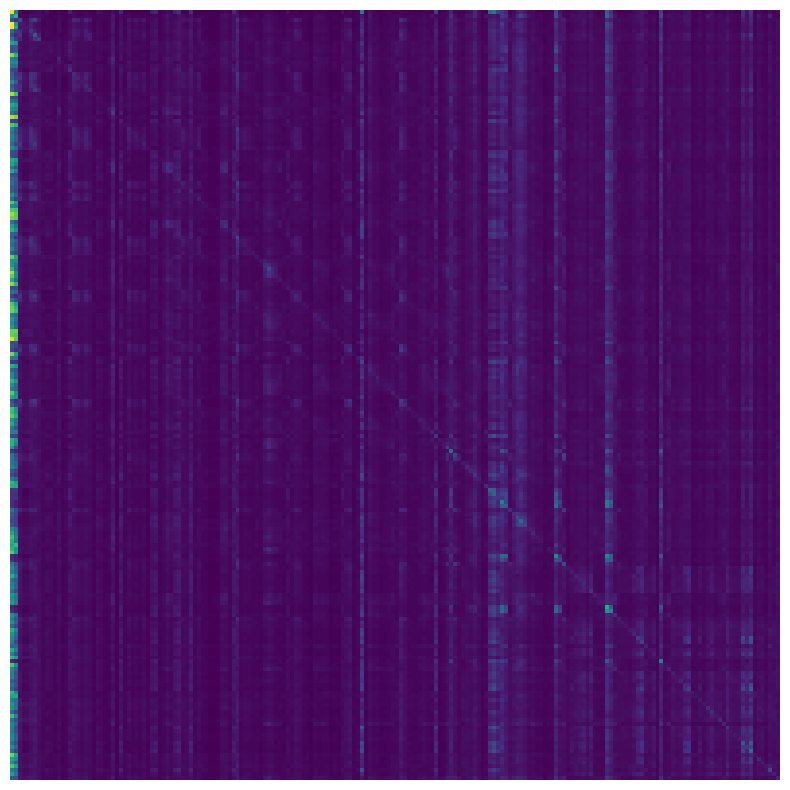

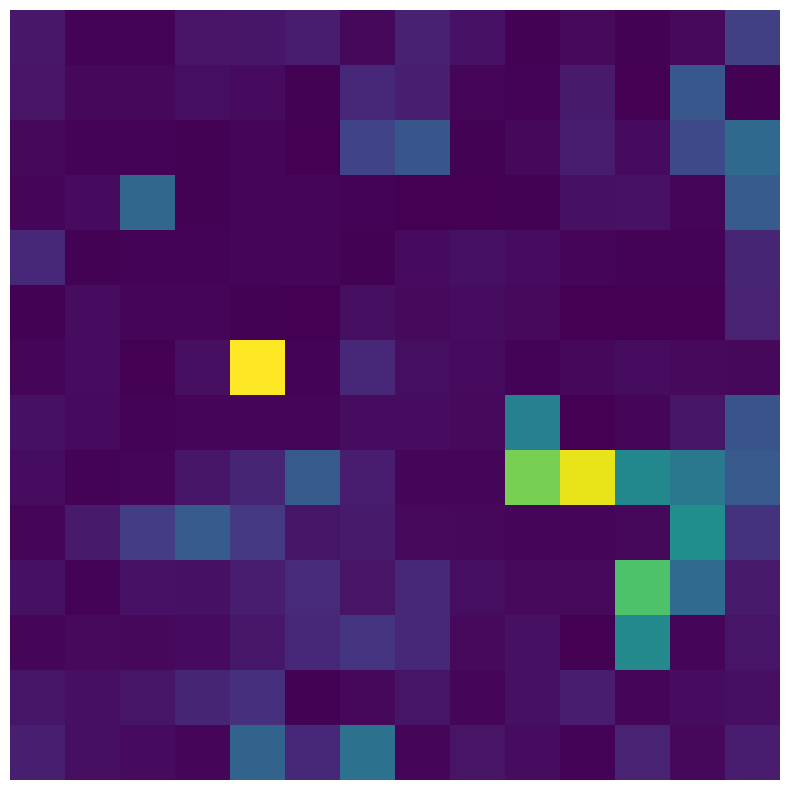

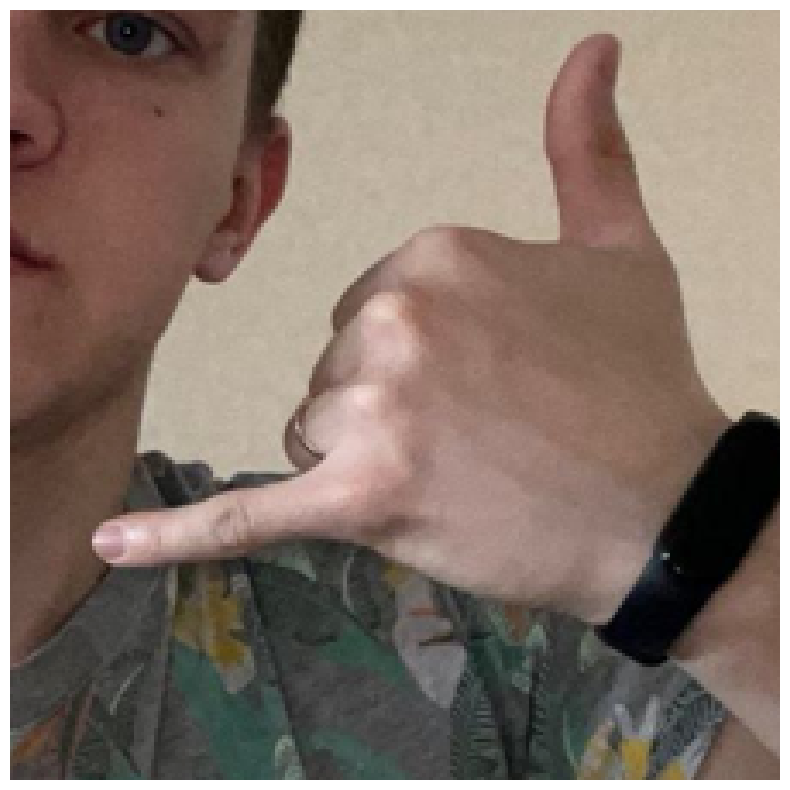

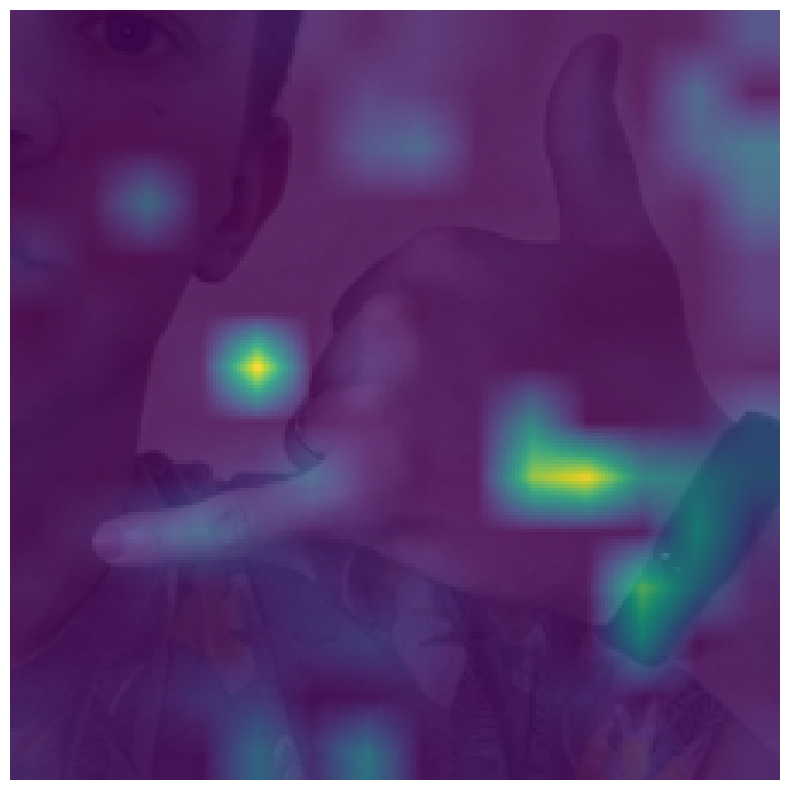

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from timm.models import create_model
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, CenterCrop, Normalize, ToTensor

def to_tensor(img):
    transform_fn = Compose([Resize(249, 3), CenterCrop(224), ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    return transform_fn(img)

def show_img(img):
    img = np.asarray(img)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def show_img2(img1, img2, alpha=0.8):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    plt.figure(figsize=(10, 10))
    plt.imshow(img1)
    plt.imshow(img2, alpha=alpha)
    plt.axis('off')
    plt.show()

def my_forward_wrapper(attn_obj):
    def my_forward(x):
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        attn_obj.cls_attn_map = attn[:, :, 0, 2:]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return my_forward

img = Image.open('../../../dataset/hagrid/hagrid-min/call/ef12e399-d421-411d-a970-08ad95a805fc.jpeg')
x = to_tensor(img)

model = create_model('deit_small_distilled_patch16_224', pretrained=True)
model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)

y = model(x.unsqueeze(0))
attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).view(14, 14).detach()

img_resized = x.permute(1, 2, 0) * 0.5 + 0.5
cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)

show_img(img)
show_img(attn_map)
show_img(cls_weight)
show_img(img_resized)
show_img2(img_resized, cls_resized, alpha=0.8)